In [45]:
import numpy as np
from pandas import read_csv
from random import shuffle
from math import floor

import keras
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import sklearn.metrics

In [70]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


In [34]:
# Load data
X = read_csv("data/fow_ann_X.csv").to_numpy()
Y = read_csv("data/fow_ann_Y.csv").to_numpy()

In [35]:
# Split into training, testing, validation
n_rows = X.shape[0]
shuffle_idx = list(range(n_rows))
shuffle(shuffle_idx)

X = X[shuffle_idx, :]
Y = Y[shuffle_idx, :]

split = (0.8, 0.1, 0.1)
split_idx = (floor(split[0]*n_rows) - 1, floor((split[0] + split[1])*n_rows) - 1)
X_train = X[0:split_idx[0],:]
Y_train = Y[0:split_idx[0],:]
X_val = X[split_idx[0]+1:split_idx[1],:]
Y_val = Y[split_idx[0]+1:split_idx[1],:]
X_test = X[split_idx[1]+1:,:]
Y_test = Y[split_idx[1]+1:,:]

## Model

In [75]:
nW = np.sum(Y_train)
nno = Y.shape[0] - nW
initial_bias = np.log([nW/nno])
output_bias = keras.initializers.Constant(initial_bias)

total = nW + nno
weight_for_0 = (1 / nno)*(total)/2.0 
weight_for_1 = (1 / nW)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}


model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))

In [76]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=METRICS)

In [92]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=2048, validation_data=(X_val, Y_val), class_weight=class_weight)

Epoch 1/50
331/331 [==============================] - 2s 5ms/step - loss: 0.7447 - tp: 8194.0000 - fp: 388506.0000 - tn: 278065.0000 - fn: 2962.0000 - accuracy: 0.4224 - precision: 0.0207 - recall: 0.7345 - auc: 0.6234 - prc: 0.0281 - val_loss: 0.7785 - val_tp: 1001.0000 - val_fp: 50431.0000 - val_tn: 32932.0000 - val_fn: 351.0000 - val_accuracy: 0.4006 - val_precision: 0.0195 - val_recall: 0.7404 - val_auc: 0.6200 - val_prc: 0.0284
Epoch 2/50
331/331 [==============================] - 2s 5ms/step - loss: 0.7441 - tp: 8222.0000 - fp: 387291.0000 - tn: 279280.0000 - fn: 2934.0000 - accuracy: 0.4242 - precision: 0.0208 - recall: 0.7370 - auc: 0.6258 - prc: 0.0289 - val_loss: 0.7653 - val_tp: 988.0000 - val_fp: 48914.0000 - val_tn: 34449.0000 - val_fn: 364.0000 - val_accuracy: 0.4183 - val_precision: 0.0198 - val_recall: 0.7308 - val_auc: 0.6227 - val_prc: 0.0288
Epoch 3/50
331/331 [==============================] - 2s 5ms/step - loss: 0.7431 - tp: 8159.0000 - fp: 384160.0000 - tn: 282411

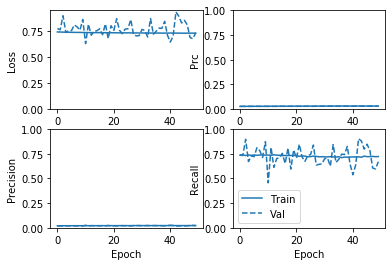

In [93]:
plot_metrics(history)

In [94]:
test_preds = model.predict(X_test, batch_size=2048)

test_W = model.predict(X_test[(Y_test == 1).reshape((X_test.shape[0],))], batch_size=2048)
test_no = model.predict(X_test[(Y_test == 0).reshape((X_test.shape[0],))], batch_size=2048)

for name, value in zip(model.metrics_names, test_preds):
  print(name, ': ', value)
print()

print("====Wickets only====")
for name, value in zip(model.metrics_names, test_W):
  print(name, ': ', value)
print()

print("====NOs only====")
for name, value in zip(model.metrics_names, test_no):
  print(name, ': ', value)
print()

#plot_roc("Test Baseline", Y_test, test_preds)

loss :  [0.57617736]
tp :  [0.69159746]
fp :  [0.5284235]
tn :  [0.5186862]
fn :  [0.618629]
accuracy :  [0.49998468]
precision :  [0.37778562]
recall :  [0.65082383]
auc :  [0.76410055]
prc :  [0.35685232]

====Wickets only====
loss :  [0.54606265]
tp :  [0.8376732]
fp :  [0.5703583]
tn :  [0.6775379]
fn :  [0.5222392]
accuracy :  [0.40939805]
precision :  [0.407112]
recall :  [0.4830088]
auc :  [0.45486367]
prc :  [0.4642046]

====NOs only====
loss :  [0.57617736]
tp :  [0.69159746]
fp :  [0.5284235]
tn :  [0.5186862]
fn :  [0.618629]
accuracy :  [0.49998468]
precision :  [0.37778562]
recall :  [0.65082383]
auc :  [0.76410055]
prc :  [0.35685232]

